In [2]:
!pip install tqdm

import keras
import tensorflow as tf
import numpy as np
import glob
import cv2
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import pickle

    100% |████████████████████████████████| 51kB 3.5MB/s ta 0:00:011


Using TensorFlow backend.


In [17]:
from keras.applications.resnet50 import ResNet50
from keras.layers import Activation, Dense, Flatten
from keras.models import Model
from keras.optimizers import SGD, Adam

In [30]:
backbone = ResNet50(include_top=False, input_shape=(224, 224, 1), pooling='avg', weights=None)

In [33]:
FREEZE_BACKBONE = False

if FREEZE_BACKBONE:
    for layer in backbone.layers:
        layer.trainable = False

x = backbone.output
#x = Dense(256, activation='relu')(x)
# x = Flatten()(x)
x = Dense(6)(x)
# x = Activation('linear')(x)
output_layer = x

model = Model(backbone.input, output_layer)
optimizer = SGD(lr=0.0001, decay=1e-6, momentum=0.95, nesterov=True)
optimizer = Adam(lr=1e-4)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

In [34]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 1)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [35]:
ins = pd.read_csv('whale_inputs.csv')
ins['source'] = ins['source'].apply(lambda s: s.split('/')[-1])
ins

,id,source,ref
0,1,0000e88ab.jpg,NaN
1,2,0001f9222.jpg,NaN
2,3,00029d126.jpg,NaN
3,4,00050a15a.jpg,NaN
4,5,0005c1ef8.jpg,NaN
5,6,0006e997e.jpg,NaN
6,7,000a6daec.jpg,NaN
7,8,000f0f2bf.jpg,NaN
8,9,0016b897a.jpg,NaN
9,10,001c1ac5f.jpg,NaN


In [36]:
import json

outs = pd.read_csv('whale_outputs.csv')
outs['data'] = outs['data'].apply(json.loads)

In [37]:
valid = []

for src, rows in pd.merge(ins, outs, how='right', left_on='id', right_on='input_id').groupby('source'):
    if len(rows) == 3:        
        pts = {}
        for e in list(rows['data']):
            pts[e['label']] = e['data'][0]

        if len(pts.keys()) == 3:
            valid.append((src, pts['upper_left'] + pts['middle'] + pts['upper_right']))
        else:
            print("Image " + str(rows.iloc[0]['id_x']) + " has multiple of the same annotation")
    else:
        print("Image " + str(rows.iloc[0]['id_x']) + " has " + str(len(rows)) + " annotations.")

Image 4 has 4 annotations.
Image 6 has 4 annotations.
Image 261 has multiple of the same annotation
Image 15000 has 1 annotations.
Image 25013 has multiple of the same annotation
Image 25096 has multiple of the same annotation
Image 25169 has multiple of the same annotation


In [38]:
!pip install imgaug
import imgaug as ia
import imgaug.augmenters as iaa

In [39]:
seq = iaa.Sequential([
    # iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        shear=(-8, 8)
    )
])

flipper = iaa.Fliplr(1)

def datagen(data, batch_size=32, do_augment=True):
    y = np.array([e[1] for e in data])
    
    while True:
        new_y = []
        imgs = []

        indices = np.random.choice(len(data), batch_size)

        for idx in indices:
            # Do this on batch level
            seq_det = seq.to_deterministic()

            im = cv2.imread('data/train/' + data[idx][0], 0)
            # Fix y annot
            h, w = im.shape
            ny = np.copy(y[idx])

            keypoints = ia.KeypointsOnImage([
                ia.Keypoint(x=ny[0], y=ny[1]),
                ia.Keypoint(x=ny[2], y=ny[3]),
                ia.Keypoint(x=ny[4], y=ny[5]),
            ], shape=im.shape)
            
            if do_augment:
                im = seq_det.augment_image(im)
                keypoints = seq_det.augment_keypoints([keypoints])[0]
            
            # Randomly flip some stuff
            if do_augment and np.random.random() > .5:
                im = flipper.augment_image(im)
                keypoints_aug = flipper.augment_keypoints([keypoints])[0]    
                kps = keypoints_aug.keypoints
                
                ny[0] = kps[2].x
                ny[1] = kps[2].y
                ny[2] = kps[1].x
                ny[3] = kps[1].y
                ny[4] = kps[0].x
                ny[5] = kps[0].y
            else:
                kps = keypoints.keypoints

                ny[0] = kps[0].x
                ny[1] = kps[0].y
                ny[2] = kps[1].x
                ny[3] = kps[1].y
                ny[4] = kps[2].x
                ny[5] = kps[2].y             
            
            ny[0] /= float(w)
            ny[2] /= float(w)
            ny[4] /= float(w)
            ny[1] /= float(h)
            ny[3] /= float(h)
            ny[5] /= float(h)
            
            im = cv2.resize(im, (224, 224))
            im = im.astype(np.float32)/255.
            im = np.expand_dims(im, axis=2)
            imgs.append(im)
            new_y.append(ny)
            
        imgs = np.array(imgs)
        new_y = np.array(new_y)
        
        yield imgs, new_y

In [40]:
np.random.shuffle(valid)
thresh = int(.85 * len(valid))
data_train = valid[:thresh]
data_val = valid[thresh:]

In [41]:
imgs, real_y = next(datagen(data_val))

In [42]:
model.fit_generator(
    datagen(data_train, batch_size=64),
    validation_data=datagen(data_val, do_augment=False),
    epochs=1000,
    steps_per_epoch=1000,
    validation_steps=100,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
        keras.callbacks.ModelCheckpoint('model_affine3.h5', save_best_only=True),
        keras.callbacks.TensorBoard('humpback_logs2')
    ]
)

Epoch 1/1000
1000/1000 [==============================] - 400s 400ms/step - loss: 0.0386 - mean_absolute_error: 0.1276 - val_loss: 0.0436 - val_mean_absolute_error: 0.1339
Epoch 2/1000
1000/1000 [==============================] - 399s 399ms/step - loss: 0.0113 - mean_absolute_error: 0.0769 - val_loss: 0.0295 - val_mean_absolute_error: 0.0934
Epoch 3/1000
1000/1000 [==============================] - 404s 404ms/step - loss: 0.0069 - mean_absolute_error: 0.0600 - val_loss: 0.0195 - val_mean_absolute_error: 0.0780
Epoch 4/1000
1000/1000 [==============================] - 405s 405ms/step - loss: 0.0048 - mean_absolute_error: 0.0497 - val_loss: 0.0099 - val_mean_absolute_error: 0.0639
Epoch 5/1000
1000/1000 [==============================] - 400s 400ms/step - loss: 0.0033 - mean_absolute_error: 0.0416 - val_loss: 0.0317 - val_mean_absolute_error: 0.0721
Epoch 6/1000
1000/1000 [==============================] - 399s 399ms/step - loss: 0.0027 - mean_absolute_error: 0.0369 - val_loss: 0.0078 - 

In [31]:
from keras.models import load_model
model = load_model('model_affine2.h5')

In [43]:
imgs, real_y = next(datagen(data_val, do_augment=False))

In [44]:
preds = model.predict(imgs)

In [45]:
import matplotlib.pyplot as plt

In [46]:
preds

array([[ 0.02711482,  0.3748885 ,  0.5079949 ,  0.44112504,  0.9670602 ,
         0.3231048 ],
       [ 0.08102528,  0.15610255,  0.47580683,  0.45712185,  0.87723964,
         0.0719737 ],
       [ 0.02920947,  0.2649803 ,  0.49775666,  0.55959797,  0.96561545,
         0.268664  ],
       [ 0.03824488,  0.3443556 ,  0.4864558 ,  0.5154926 ,  0.95777494,
         0.36956787],
       [ 0.10321422,  0.0582298 ,  0.5030164 ,  0.5282543 ,  0.9842062 ,
         0.04443329],
       [ 0.05561797,  0.04187936,  0.48417008,  0.60193425,  0.9890197 ,
         0.05236681],
       [ 0.04706707,  0.29508072,  0.4997818 ,  0.5124073 ,  0.96409744,
         0.30664584],
       [ 0.22061616,  0.3117971 ,  0.48854584,  0.42678115,  0.95225894,
         0.28519893],
       [ 0.03381129,  0.30542138,  0.473105  ,  0.41967407,  0.96927905,
         0.218298  ],
       [ 0.08102528,  0.15610255,  0.47580683,  0.45712185,  0.87723964,
         0.0719737 ],
       [ 0.04143067,  0.32109818,  0.46442717,  0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

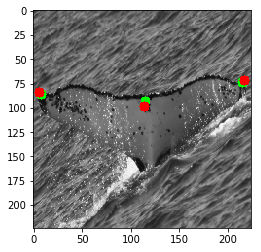

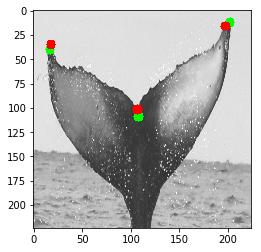

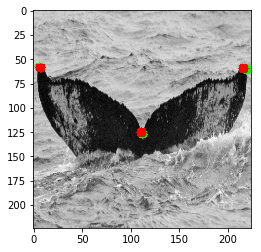

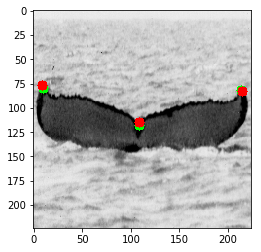

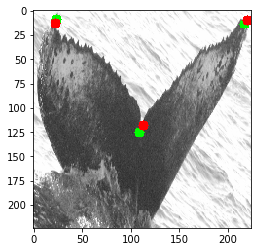

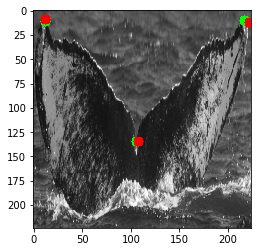

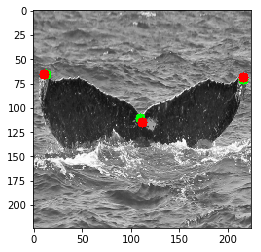

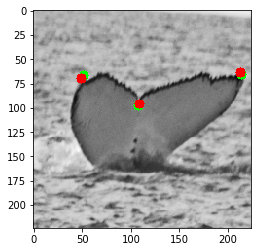

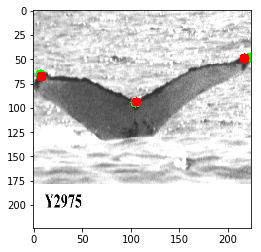

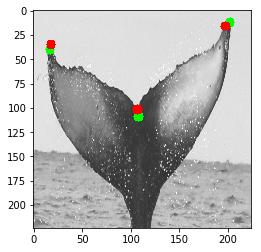

In [47]:
for im, pred, real in zip(imgs, preds[:10], real_y):
    im = np.copy(im)
    im = cv2.cvtColor(im.squeeze(), cv2.COLOR_GRAY2RGB)
    
    x0, y0, x1, y1, x2, y2 = np.round(real * 224).astype(np.int32)
    cv2.circle(im,(x0, y0), 5, (0,255,0), -1)
    cv2.circle(im,(x1, y1), 5, (0,255,0), -1)
    cv2.circle(im,(x2, y2), 5, (0,255,0), -1)
    
    x0, y0, x1, y1, x2, y2 = np.round(pred * 224).astype(np.int32)
    cv2.circle(im,(x0, y0), 5, (255,0,0), -1)
    cv2.circle(im,(x1, y1), 5, (255,0,0), -1)
    cv2.circle(im,(x2, y2), 5, (255,0,0), -1)
    plt.figure()
    plt.imshow(im)


## Collecting all data and outputting

In [48]:
def load_img(fname):
    return cv2.imread(fname)

def preprocess(im):
    im = np.copy(im)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im = cv2.resize(im, (224, 224))
    im = im.astype(np.float32)/255.
    im = np.expand_dims(im, axis=2)
    return im

imgs = []

for fname in tqdm(glob.glob('data/train/*.jpg')):
    imgs.append((fname, load_img(fname)))
    
for fname in tqdm(glob.glob('test_data/*.jpg')):
    imgs.append((fname, load_img(fname)))

In [49]:
fnames = [e.split('/')[-1] for e, _ in imgs]
images = [e for _, e in imgs]
prepped = np.array([preprocess(e) for _, e in imgs])

In [50]:
preds = model.predict(prepped, verbose=1)

33321/33321 [==============================] - 46s 1ms/step


In [51]:
with open('tail_keypoints.csv', 'w') as f:
    print('image,left_x,left_y,mid_x,mid_y,right_x,right_y', file=f)
    for fname, img, pred in zip(fnames, images, preds):
        h, w = img.shape[:2]

        lx = int(w * pred[0])
        ly = int(h * pred[1])
        mx = int(w * pred[2])
        my = int(h * pred[3])
        rx = int(w * pred[4])
        ry = int(h * pred[5])

        print(','.join([fname] + [str(x) for x in [lx, ly, mx, my, rx, ry]]), file=f)

In [77]:
for fname, img, pred in zip(fnames, images, preds):
    h, w = img.shape[:2]

    lx = int(w * pred[0])
    ly = int(h * pred[1])
    mx = int(w * pred[2])
    my = int(h * pred[3])
    rx = int(w * pred[4])
    ry = int(h * pred[5])

    print(','.join([fname] + [str(x) for x in [lx, ly, mx, my, rx, ry]]))
    break

5993e9c5a.jpg,6,148,348,196,668,96
